In [32]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import seaborn as sns 
import matplotlib.pyplot as plt 
from colorama import Fore

from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

np.random.seed(0)

In [33]:
df = pd.read_csv("/kaggle/input/acea-water-prediction/Aquifer_Petrignano.csv")
df.head()

,Date,Rainfall_Bastia_Umbra,Depth_to_Groundwater_P24,Depth_to_Groundwater_P25,Temperature_Bastia_Umbra,Temperature_Petrignano,Volume_C10_Petrignano,Hydrometry_Fiume_Chiascio_Petrignano
0,14/03/2006,NaN,-22.48,-22.18,NaN,NaN,NaN,NaN
1,15/03/2006,NaN,-22.38,-22.14,NaN,NaN,NaN,NaN
2,16/03/2006,NaN,-22.25,-22.04,NaN,NaN,NaN,NaN
3,17/03/2006,NaN,-22.38,-22.04,NaN,NaN,NaN,NaN
4,18/03/2006,NaN,-22.60,-22.04,NaN,NaN,NaN,NaN


In [34]:
df.isna().sum()

Date                                       0
Rainfall_Bastia_Umbra                   1024
Depth_to_Groundwater_P24                  55
Depth_to_Groundwater_P25                  39
Temperature_Bastia_Umbra                1024
Temperature_Petrignano                  1024
Volume_C10_Petrignano                    198
Hydrometry_Fiume_Chiascio_Petrignano    1024
dtype: int64

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5223 entries, 0 to 5222
Data columns (total 8 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Date                                  5223 non-null   object 
 1   Rainfall_Bastia_Umbra                 4199 non-null   float64
 2   Depth_to_Groundwater_P24              5168 non-null   float64
 3   Depth_to_Groundwater_P25              5184 non-null   float64
 4   Temperature_Bastia_Umbra              4199 non-null   float64
 5   Temperature_Petrignano                4199 non-null   float64
 6   Volume_C10_Petrignano                 5025 non-null   float64
 7   Hydrometry_Fiume_Chiascio_Petrignano  4199 non-null   float64
dtypes: float64(7), object(1)
memory usage: 326.6+ KB


Need to fix the date column in order for dates to be read as dates instead of a string

In [39]:
# Removing old rows
df = df[df.Rainfall_Bastia_Umbra.notna()].reset_index(drop = True)
# removing columns with mostly missing values/ Nan
df = df.drop(['Depth_to_Groundwater_P24', 'Temperature_Petrignano'], axis = 1)

KeyError: "['Depth_to_Groundwater_P24', 'Temperature_Petrignano'] not found in axis"

In [40]:
# Simple column names 
df.columns = ['date', 'rainfall','depth_to_groundwater','temperature','drainage_volume','river_hydrometry']

targets = ['depth_to_groundwater']
features = [feature for feature in df.columns if feature not in targets]
df.head()

,date,rainfall,depth_to_groundwater,temperature,drainage_volume,river_hydrometry
0,01/01/2009,0.0,-31.14,5.2,-24530.688,2.4
1,02/01/2009,0.0,-31.11,2.3,-28785.888,2.5
2,03/01/2009,0.0,-31.07,4.4,-25766.208,2.4
3,04/01/2009,0.0,-31.05,0.8,-27919.296,2.4
4,05/01/2009,0.0,-31.01,-1.9,-29854.656,2.3


In [41]:
from datetime import datetime, date

df['date'] = pd.to_datetime(df['date'], format = '%d/%m/%Y')
df.head().style.set_properties(subset = ['date'], **{'background-color' : 'skyblue'})

,date,rainfall,depth_to_groundwater,temperature,drainage_volume,river_hydrometry
0,2009-01-01 00:00:00,0.000000,-31.140000,5.200000,-24530.688000,2.400000
1,2009-01-02 00:00:00,0.000000,-31.110000,2.300000,-28785.888000,2.500000
2,2009-01-03 00:00:00,0.000000,-31.070000,4.400000,-25766.208000,2.400000
3,2009-01-04 00:00:00,0.000000,-31.050000,0.800000,-27919.296000,2.400000
4,2009-01-05 00:00:00,0.000000,-31.010000,-1.900000,-29854.656000,2.300000


## Data Visualization

- **`Rainfall`**: indicates the quantity of rainfall in (mm)
- **`Temperature`**: indicates the tempreature (C)
- **`Volume`**: indicates the volume of water taken from drinking water treatment plant (m^3)
- **`Depth to Groundwater`**: indicates the groundwater level (meters from the ground floor)

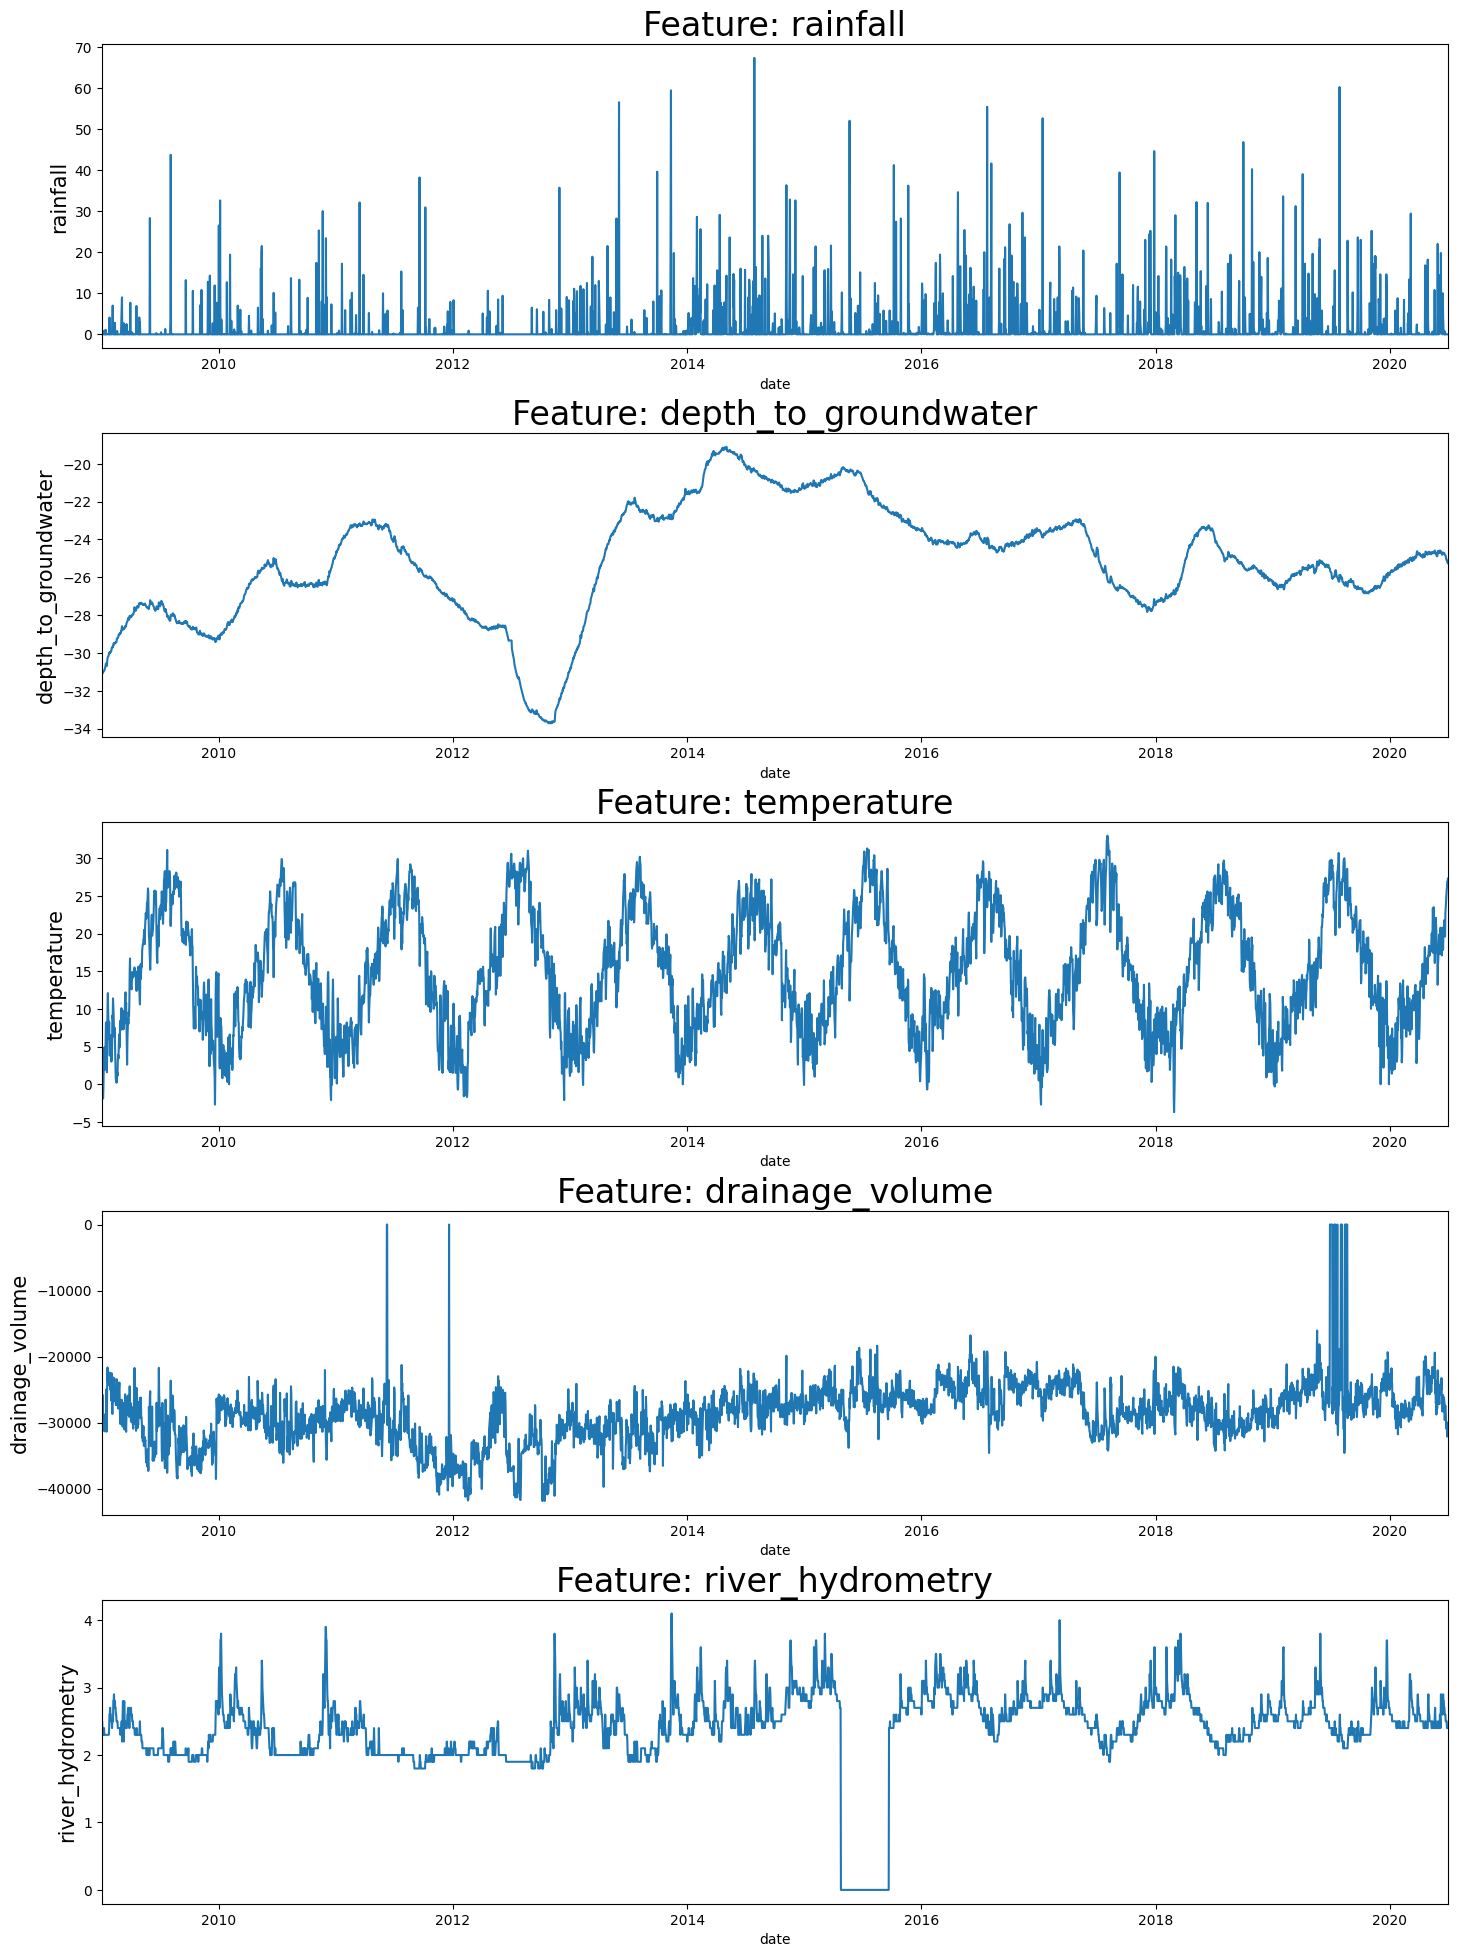

In [42]:
fig, ax = plt.subplots(nrows = 5, ncols = 1, figsize=(15,20))
plt.tight_layout(pad = 4)

for i,column in enumerate(df.drop('date', axis = 1).columns):
    sns.lineplot(x=df['date'], y = df[column].fillna(method = 'ffill'), ax = ax[i])
    ax[i].set_title(f"Feature: {column}", fontsize = 24)
    ax[i].set_ylabel(ylabel = column, fontsize = 15)
    ax[i].set_xlim([date(2009,1,1), date(2020,6,30)])

## Data PreProcessing

### Chronological order and equidistant timestamps 

need to have the data in chronological order by sorting `df` by `date`. Having equidistant timestamps indicates constant time intervals, can do this by taking a difference between timestamps or set a constant time interval and resample the dates. 

In [43]:
df = df.sort_values(by='date')
# check time intervals 
df['delta'] = df['date'] - df['date'].shift(1)

df[['date', 'delta']].head()

,date,delta
0,2009-01-01,NaT
1,2009-01-02,1 days
2,2009-01-03,1 days
3,2009-01-04,1 days
4,2009-01-05,1 days


In [44]:
df['delta'].sum() ,df['delta'].count()

(Timedelta('4198 days 00:00:00'), 4198)

### Handling missing values

Some of the missing values and some missing that are zeros. cleaning by replacing the nan values and filling them

In [45]:
df = df.drop('delta', axis = 1)
df.isna().sum()

date                     0
rainfall                 0
depth_to_groundwater    27
temperature              0
drainage_volume          1
river_hydrometry         0
dtype: int64

(14245.0, 18443.0)

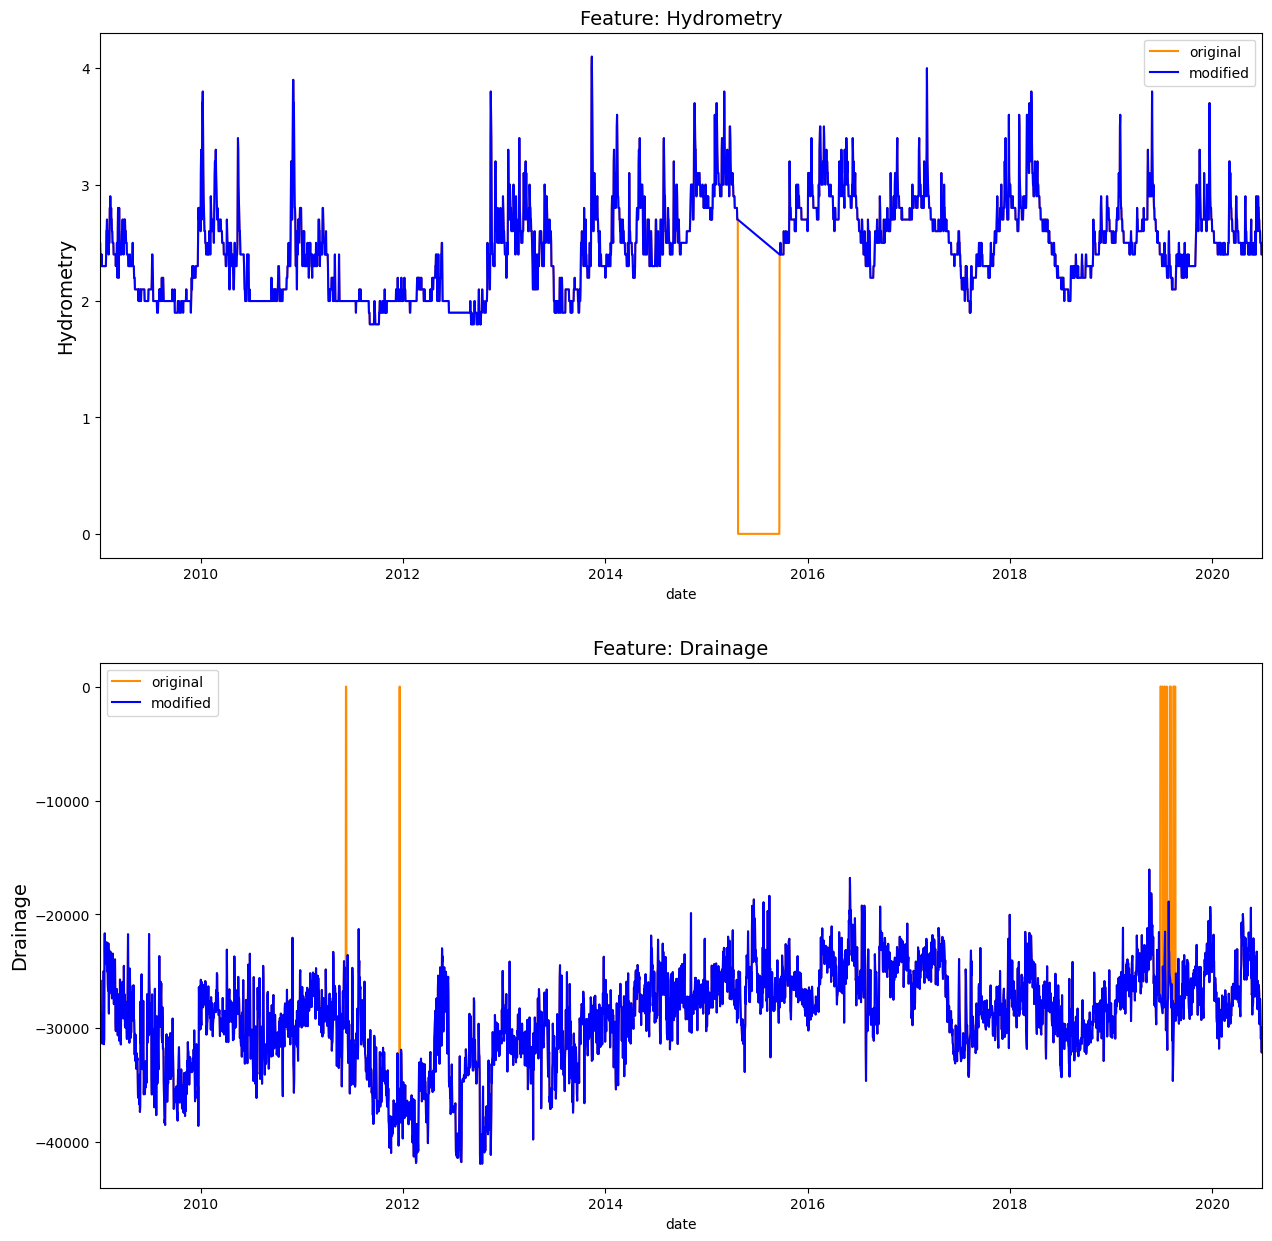

In [46]:
fig, axs = plt.subplots(nrows = 2, ncols = 1, figsize=(15,15))

old_hydrometry = df['river_hydrometry'].copy()
df['river_hydrometry'] = df['river_hydrometry'].replace(0, np.nan)

sns.lineplot(x=df['date'], y = old_hydrometry, 
             ax = axs[0], color = 'darkorange', 
             label = 'original')
sns.lineplot(x=df['date'], y = df['river_hydrometry'].fillna(np.inf), ax = axs[0], color = 'blue', label = 'modified')
axs[0].set_title("Feature: Hydrometry", fontsize = 14)
axs[0].set_ylabel(ylabel = "Hydrometry", fontsize = 14)
axs[0].set_xlim([date(2009,1,1), date(2020,6,30) ])

old_drainage = df['drainage_volume'].copy()
df['drainage_volume'] = df['drainage_volume'].replace(0, np.nan)

sns.lineplot(x=df['date'], y = old_drainage, ax=axs[1], color='darkorange', label='original')
sns.lineplot(x=df['date'], y=df['drainage_volume'].fillna(np.inf), ax=axs[1], color='blue', label='modified')
axs[1].set_title("Feature: Drainage", fontsize=14)
axs[1].set_ylabel(ylabel="Drainage", fontsize=14)
axs[1].set_xlim([date(2009,1,1), date(2020,6,30)])

/tmp/ipykernel_32/2019522658.py:7: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(14)


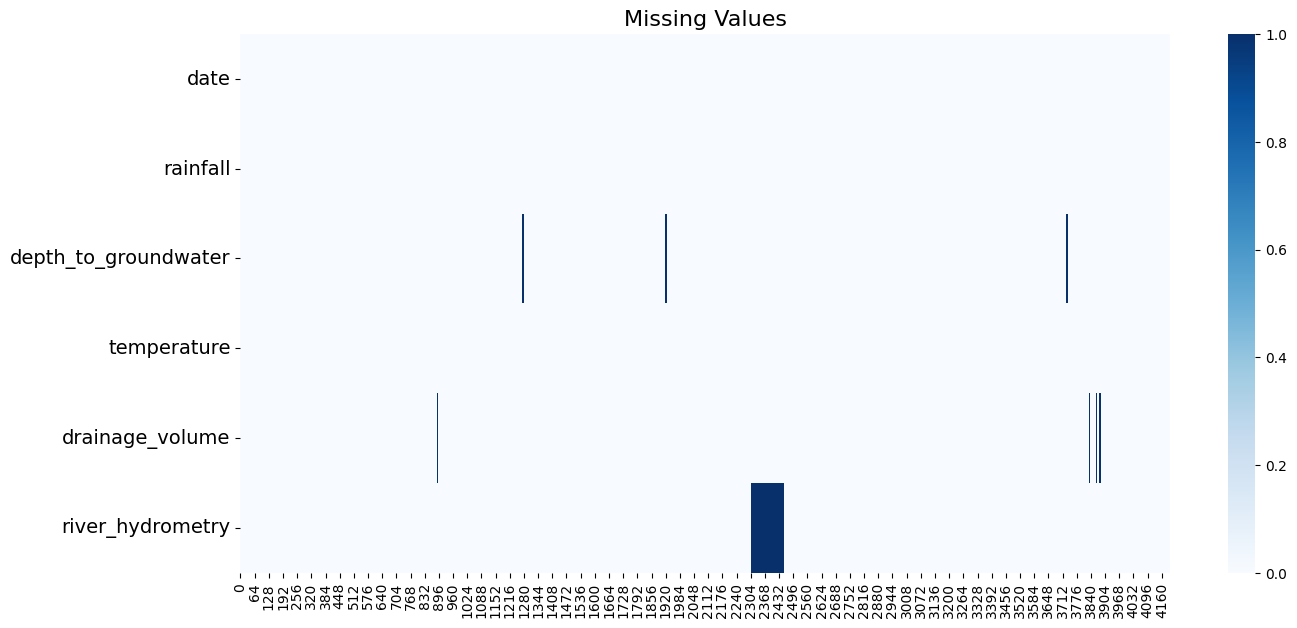

In [47]:
fig, axs = plt.subplots(1, 1, figsize=(15,7))

sns.heatmap(df.T.isna(), cmap = 'Blues')
axs.set_title("Missing Values", fontsize=16)

for tick in axs.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)
plt.show()

### Methods for hanglins missing values
1. Fill Nan with outliers or Zero:
    filling missing values like this may seem worse but often results in better modeling 

2. Fill Nan with Mean values
    May not always result in a good model

3. Fill Nan with the last value using .ffill()
    May have good results 
    
4. Fill Nan with linearly interpolated value with .interpolate()
    Might be the best option depending on the data but requires knowledge of neighboring values 

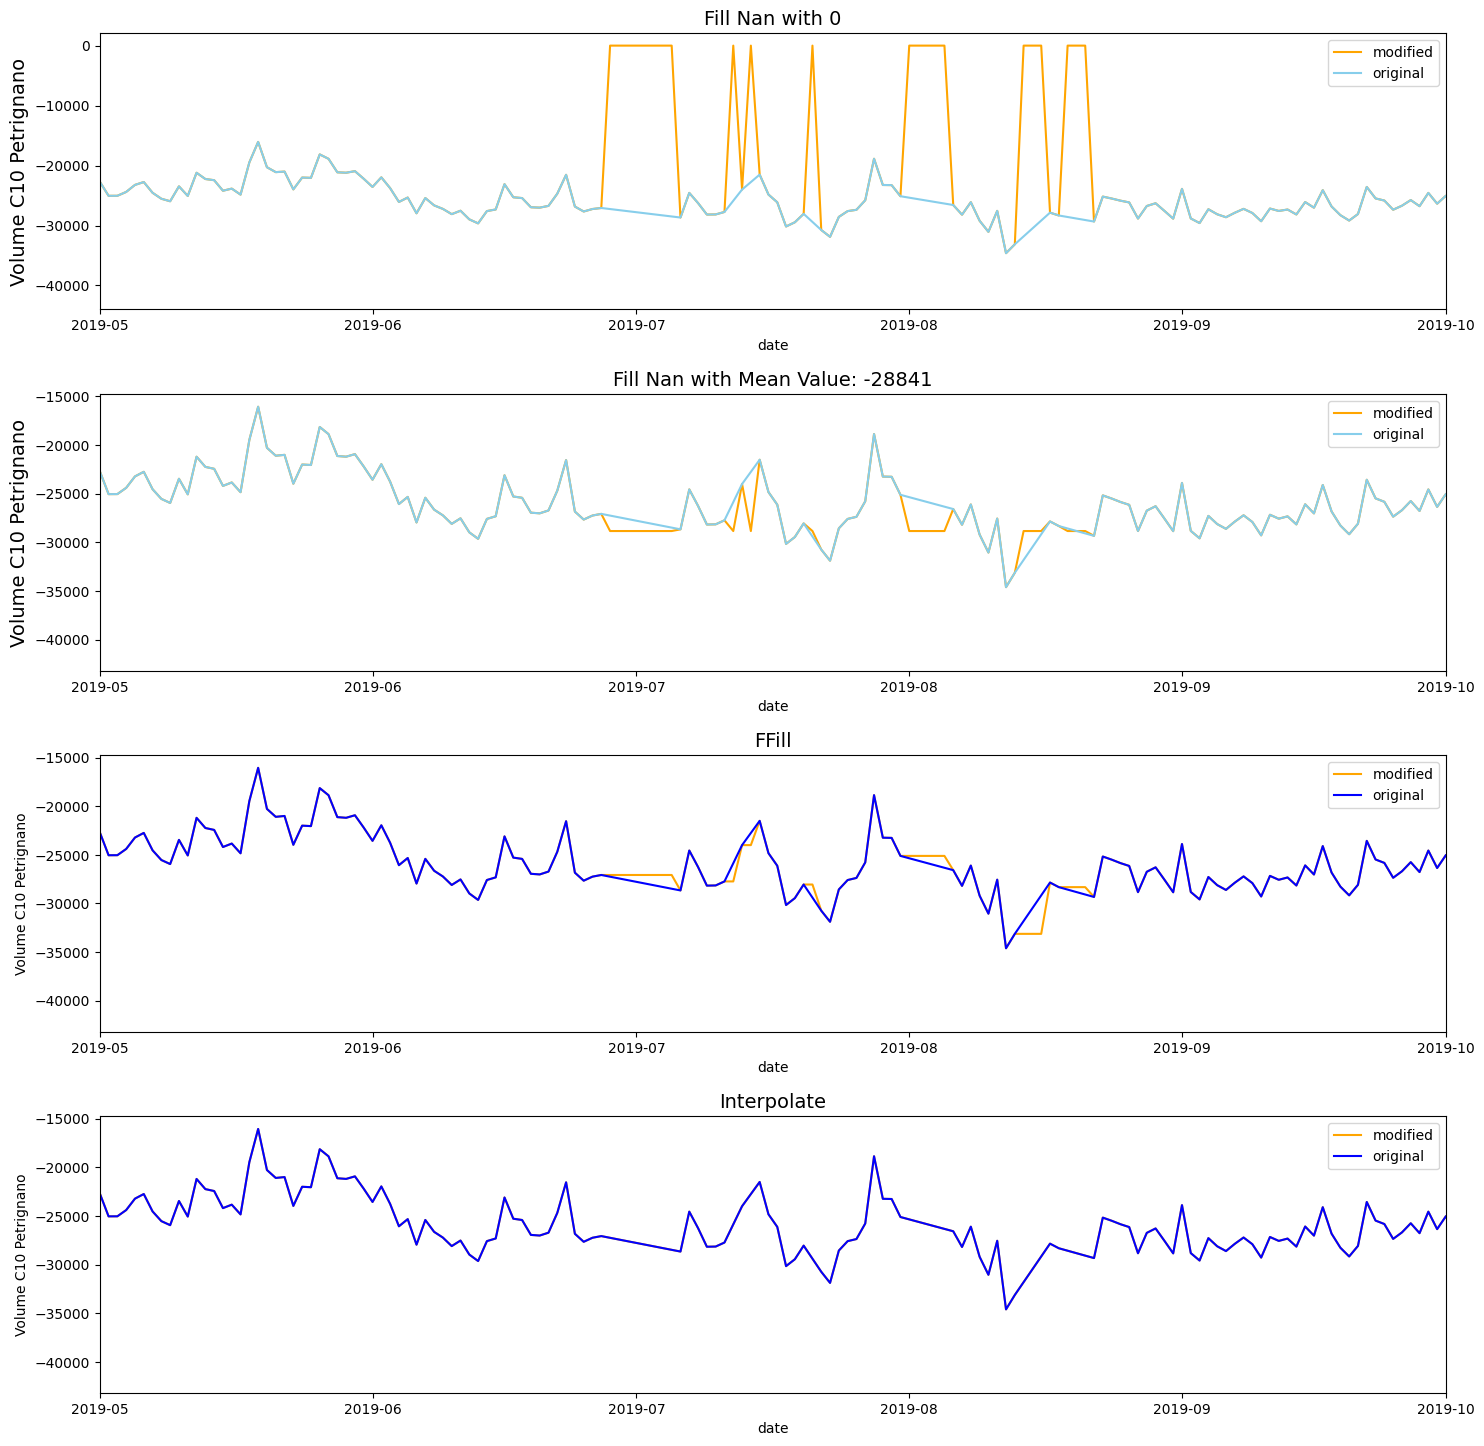

In [48]:
fig, axs = plt.subplots(4, 1, figsize=(15,15))
plt.tight_layout(pad = 4)

sns.lineplot(x=df['date'], y = df['drainage_volume'].fillna(0), ax = axs[0], color='orange', label = 'modified')
sns.lineplot(x=df['date'], y = df['drainage_volume'].fillna(np.inf), ax = axs[0], color = 'skyblue', label = 'original')
axs[0].set_title("Fill Nan with 0", fontsize = 14)
axs[0].set_ylabel(ylabel="Volume C10 Petrignano", fontsize = 14)

mean_drainage = df['drainage_volume'].mean()
sns.lineplot(x=df['date'], y=df['drainage_volume'].fillna(mean_drainage), ax = axs[1], color='orange', label = 'modified')
sns.lineplot(x=df['date'], y=df['drainage_volume'].fillna(np.inf), ax = axs[1], color = 'skyblue', label = 'original')
axs[1].set_title(f"Fill Nan with Mean Value: {mean_drainage:.0f}", fontsize = 14)
axs[1].set_ylabel(ylabel="Volume C10 Petrignano", fontsize = 14)

sns.lineplot(x=df['date'], y=df['drainage_volume'].ffill(), ax = axs[2], color = 'orange', label = 'modified')
sns.lineplot(x=df['date'], y=df['drainage_volume'].fillna(np.inf), ax=axs[2], color = 'blue', label = 'original')
axs[2].set_title("FFill", fontsize = 14)
axs[2].set_ylabel(ylabel="Volume C10 Petrignano")

sns.lineplot(x=df['date'], y=df['drainage_volume'].interpolate(), ax = axs[3], color = 'orange', label = 'modified')
sns.lineplot(x=df['date'], y =df['drainage_volume'].fillna(np.inf), ax = axs[3], color = 'blue', label = 'original')
axs[3].set_title("Interpolate", fontsize = 14)
axs[3].set_ylabel(ylabel="Volume C10 Petrignano")

for i in range(4):
    axs[i].set_xlim([date(2019,5,1), date(2019,10,1)])


In [ ]:
df['drainage_volume'] = df['drainage_volume'].interpolate()
df['river_hydrometry'] = df['river_hydrometry'].interpolate()
df['depth_to_groundwater'] = df['depth_to_groundwater'].interpolate()

### Smoothing data / Resampling 

2 types of resampling:
1. **Upsampling**: when the frequency of samples is increased (e.g. days to hours)
2. **Downsampling**: when the frequency of samples is decreased (days to weeks)

will do some downsampling with the `.resample()` function (similar to `groupby` and aggregate as mean).

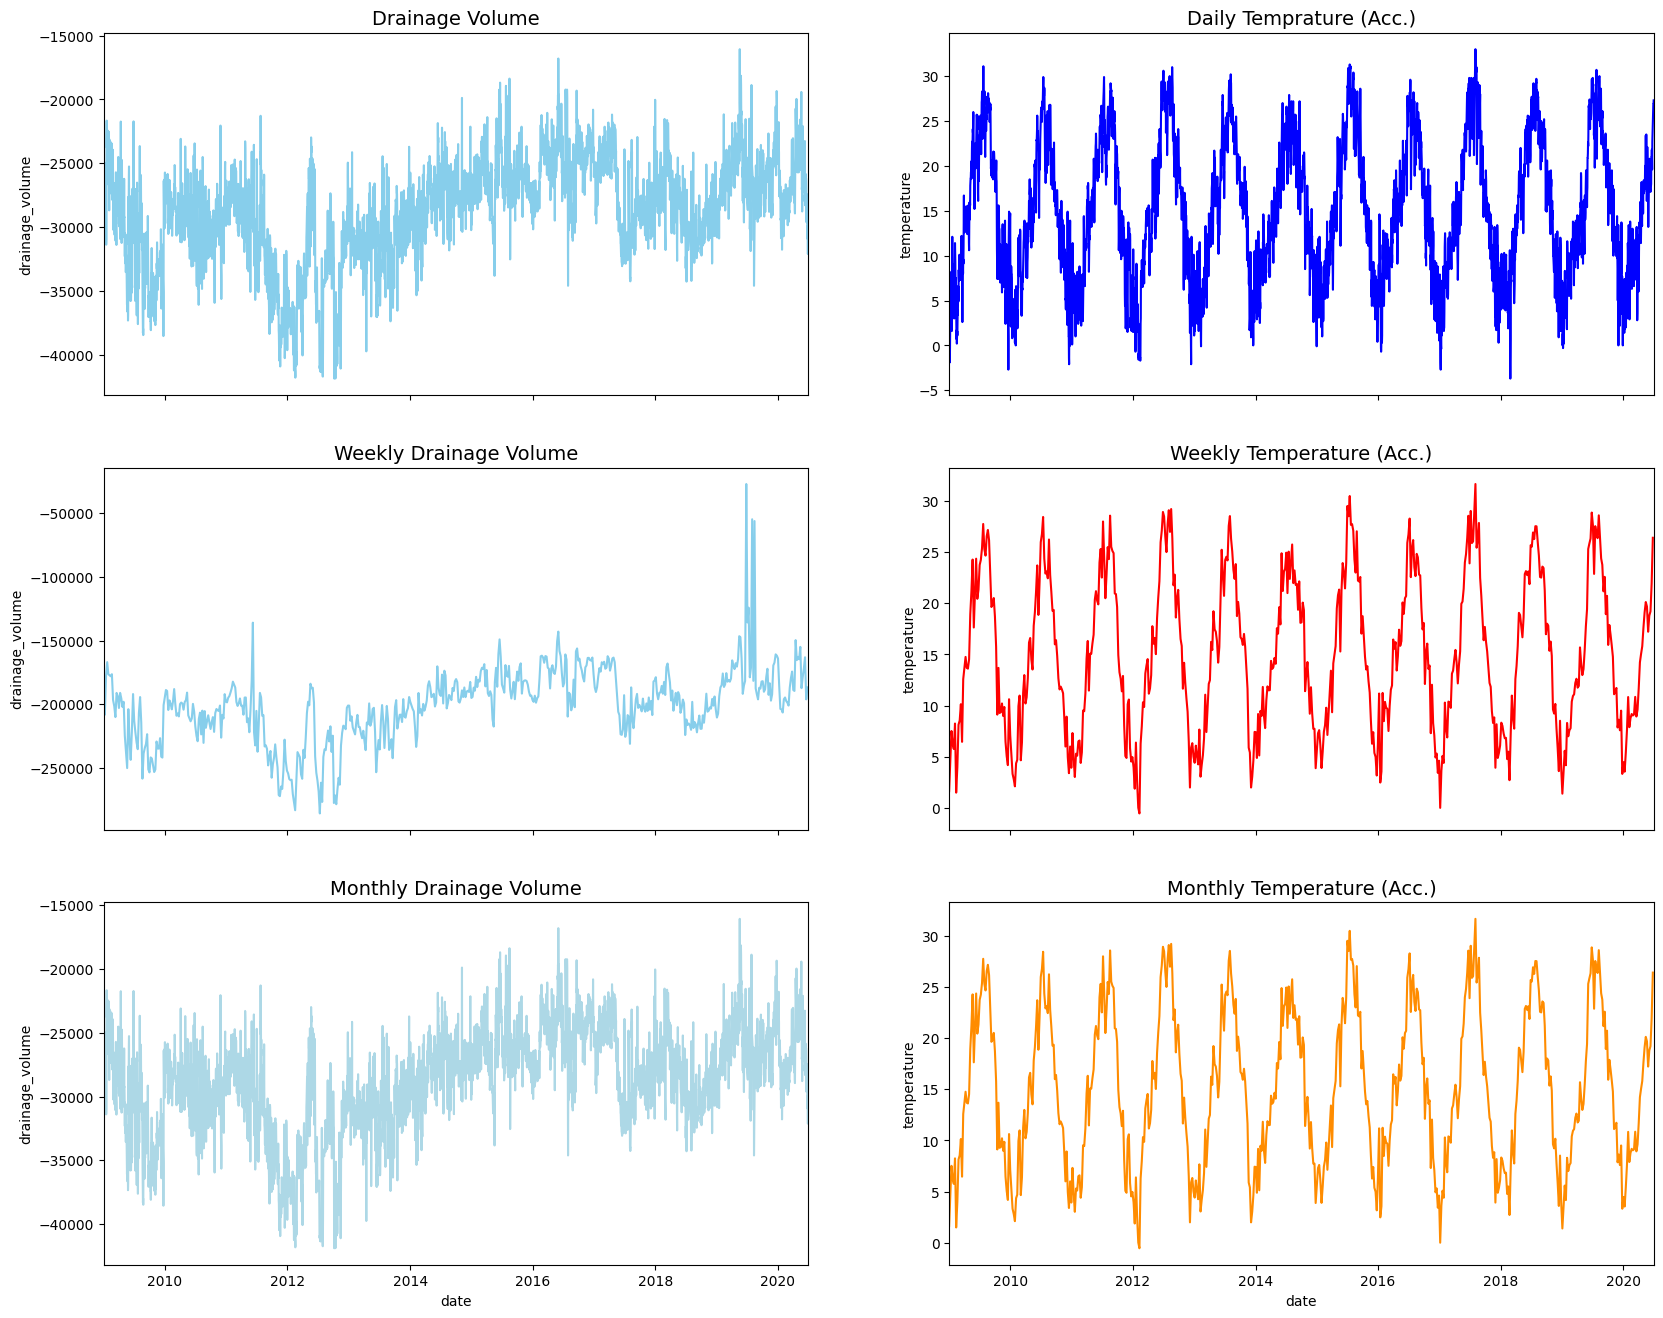

In [56]:
fig, axs = plt.subplots(ncols = 2, nrows = 3, sharex=True, figsize=(20,16))

sns.lineplot(x = df['date'], y = df['drainage_volume'], color = 'skyblue', ax = axs[0,0])
axs[0,0].set_title("Drainage Volume", fontsize = 14)

resampled_df = df[['date','drainage_volume']].resample('7D', on = 'date').sum().reset_index(drop = False)
sns.lineplot(x = resampled_df['date'], y = resampled_df['drainage_volume'], color = 'skyblue', ax = axs[1,0])
axs[1,0].set_title("Weekly Drainage Volume", fontsize = 14)

resampled_df = df[['date','drainage_volume']].resample('M', on = 'date').sum().reset_index(drop = False)
sns.lineplot(x = df['date'], y = df['drainage_volume'], color = 'lightblue', ax = axs[2,0])
axs[2,0].set_title("Monthly Drainage Volume", fontsize = 14)

for i in range(3):
    axs[i,0].set_xlim([date(2009,1,1), date(2020,6,30)])
    
sns.lineplot(x = df['date'], y = df['temperature'], color = 'blue', ax = axs[0,1])
axs[0,1].set_title("Daily Temprature (Acc.)", fontsize = 14)

resampled_df = df[['date', 'temperature']].resample("7D", on = 'date').mean().reset_index(drop = False)
sns.lineplot(x = resampled_df['date'], y = resampled_df['temperature'], color = 'red', ax = axs[1,1])
axs[1,1].set_title("Weekly Temperature (Acc.)", fontsize = 14)

resampled_Df = df[['date', 'temperature']].resample("M", on='date').mean().reset_index(drop=False)
sns.lineplot(x = resampled_df['date'], y=resampled_df['temperature'], color = 'darkorange', ax = axs[2,1])
axs[2,1].set_title("Monthly Temperature (Acc.)", fontsize = 14)

for i in range(3):
    axs[i,1].set_xlim([date(2009,1,1),date(2020,6,30)])

plt.show()

Weekly downsampling helps smooth the data and is easier for modeling 

In [ ]:
downsample = df[['date',
                'depth_to_groundwater',
                'temperature',
                'drainage_volume',
                'river_hydrometry',
                'rainfall']].resample("7D", on='date').mean().reset_index(drop = False)

df = downsample.copy()

The check for stationarity can be done with the 3 methods below:

1. **Visuall**: plot time series and check for trends or seasonality
2. **Basic Statistics**: split time series and compare the mean and variance of each partition
3. **Statistical Test**: Augmented Dickey Fuller Test


In [ ]:
rolling_window = 52

fig, axs = plt.subplots(nrows = 2, ncols = 1, figsize=(20,15))

sns.lineplot(x=df['date'], y=df['drainage_volume'], ax = axs[0], color = 'black', label = 'original')
sns.lineplot(x=df['date'], y=df['drainage_volume'].rolling(rolling_window).mean() , ax = axs[0], color = 'yellow', label = 'rolling mean')
sns.lineplot(x=df['date'], y=df['drainage_volume'].rolling(rolling_window).std() , ax = axs[0] , color = 'orange' , label = 'rolling std')
axs[0].set_title("Depth to Groundwater: Non-stationary \ nnon-constant mean & non-constant variance", )